In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding,SimpleRNN,GRU
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from string import punctuation
punct = list(punctuation)
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Administrator\AppData\Roaming\nltk_data.
[nltk_data]    |     ..
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Administrator\AppData\Roaming\nltk_data.
[nltk_data]    |     ..
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Administrator\AppData\Roaming\nltk_data.
[nltk_data]    |     ..
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Administrator\AppData\Roaming\nltk_data.
[nltk_data]    |     ..
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    |

In [5]:
#@title Load Dataset
data=pd.read_csv('D:\My_Models\TextClassification_UsingGRU.csv')
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
articles=data['text']
labels=data['category']

In [7]:
# Tokenization and cleaning functions
STOPWORDS = set()  # Define STOPWORDS if needed
punct = set(".,!?()[]{}:;\"'")  # Define punct if needed


In [8]:
def tokenize(sentence):
    return word_tokenize(sentence)

def clean(sentence):
    words = []
    for word in tokenize(sentence):
        if word not in STOPWORDS and word not in punct and not word.isdigit():
            words.append(word.lower())
    return ' '.join(words)


In [9]:
for i in tqdm(range(len(articles))):
    articles[i] = clean(articles[i])
articles.head()

100%|██████████| 2225/2225 [00:06<00:00, 321.46it/s]


0    tv future in the hands of viewers with home th...
1    worldcom boss left books alone former worldcom...
2    tigers wary of farrell gamble leicester say th...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: text, dtype: object

In [10]:
# Define parameters
vocab_size = 5000
embedding_dim = 64
max_length = 200
oov_tok = '<OOV>'  # Out of Vocabulary
training_portion = 0.8

In [11]:
len(labels),len(articles)

(2225, 2225)

In [12]:
labels[0],articles[0]

('tech',
 'tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices one of the most talked-about technologies of ces has been digital and personal video recorders dvr and pvr these set-top boxes like the us s tivo and the uk s sky+ system allow people to record store play pause and forward wind tv programmes when they want essentially the technology allows for much more personalised tv they are also being built-in to high-definition tv s

In [13]:
# Split data into training and validation sets
train_size = int(len(articles) * training_portion)
train_articles = articles[:train_size]
train_labels = labels[:train_size]
validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [14]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445


In [15]:
# Tokenize the articles
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)

In [16]:
# Convert articles into padded sequences
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [17]:
tokenizer.texts_to_sequences(['the cat sat on my table'])

[[2, 1, 1, 13, 114, 2269]]

In [18]:
# Map labels to integers
dict_ = {}
for i, x in tqdm(enumerate(set(labels))):
    dict_[x] = i

5it [00:00, ?it/s]


In [19]:
training_label_seq = np.array([dict_[train_labels[i]] for i in tqdm(range(len(train_labels)))])
validation_label_seq = np.array([dict_[np.array(validation_labels)[i]] for i in tqdm(range(len(validation_labels)))])


100%|██████████| 445/445 [00:00<00:00, 74364.13it/s]


In [20]:
train_labels[0], training_label_seq[0]

('tech', 3)

In [21]:
pd.DataFrame(training_label_seq).value_counts()

0
2    410
1    404
0    331
4    320
3    315
Name: count, dtype: int64

In [22]:
pd.DataFrame(validation_label_seq).value_counts()

0
1    106
2    101
0     86
3     86
4     66
Name: count, dtype: int64

Text(0, 0.5, 'Count')

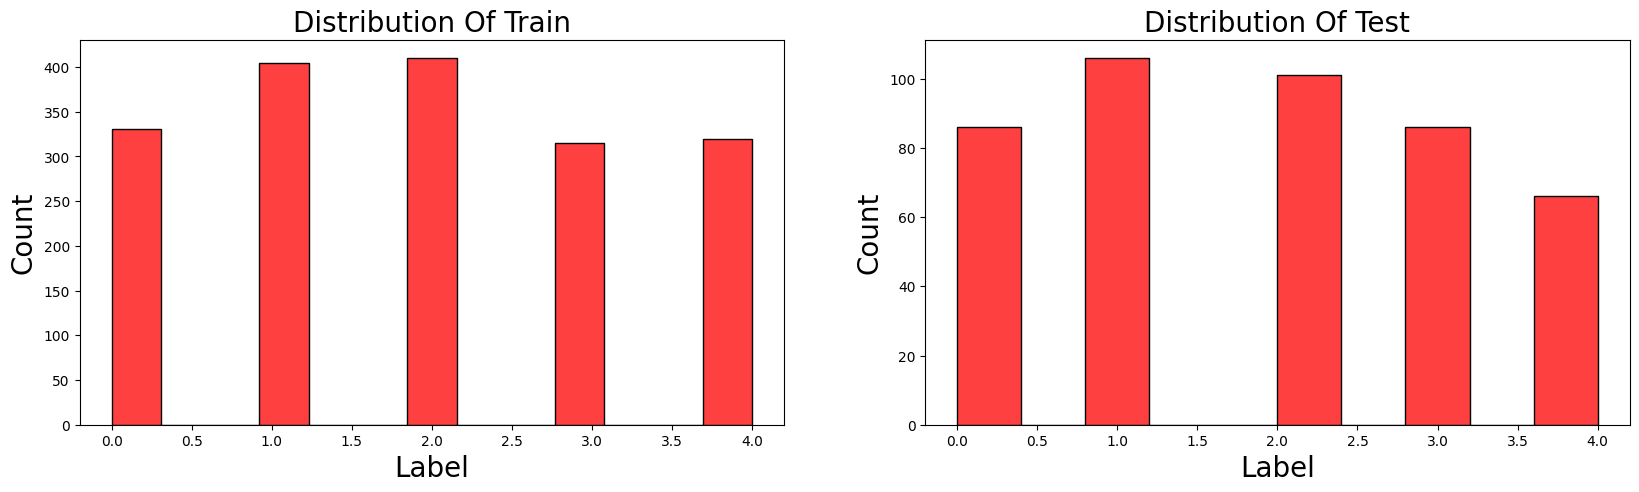

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Distribution Of Train",fontsize=20)
sns.histplot(training_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.subplot(1,2,2)
plt.title("Distribution Of Test",fontsize=20)
sns.histplot(validation_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GRU, Dense

num_classes = len(set(labels))  # Number of unique classes in your dataset

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Dropout(0.5))
model.add(GRU(units=32))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 329,573
Trainable params: 329,573
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_padded, training_label_seq, epochs=20, validation_data=(validation_padded, validation_label_seq))

Epoch 1/20
56/56 [==============================] - 8s 25ms/step - loss: 1.6026 - accuracy: 0.2416 - val_loss: 1.5941 - val_accuracy: 0.2831
Epoch 2/20
56/56 [==============================] - 1s 12ms/step - loss: 1.5719 - accuracy: 0.3191 - val_loss: 1.5599 - val_accuracy: 0.3191
Epoch 3/20
56/56 [==============================] - 1s 12ms/step - loss: 1.2899 - accuracy: 0.4517 - val_loss: 1.1582 - val_accuracy: 0.4652
Epoch 4/20
56/56 [==============================] - 1s 12ms/step - loss: 1.0306 - accuracy: 0.5461 - val_loss: 1.0327 - val_accuracy: 0.5888
Epoch 5/20
56/56 [==============================] - 1s 13ms/step - loss: 0.8090 - accuracy: 0.6556 - val_loss: 0.8346 - val_accuracy: 0.6607
Epoch 6/20
56/56 [==============================] - 1s 12ms/step - loss: 0.6153 - accuracy: 0.7326 - val_loss: 0.6926 - val_accuracy: 0.7079
Epoch 7/20
56/56 [==============================] - 1s 12ms/step - loss: 0.4913 - accuracy: 0.8163 - val_loss: 0.6745 - val_accuracy: 0.7124
Epoch 8/20
56

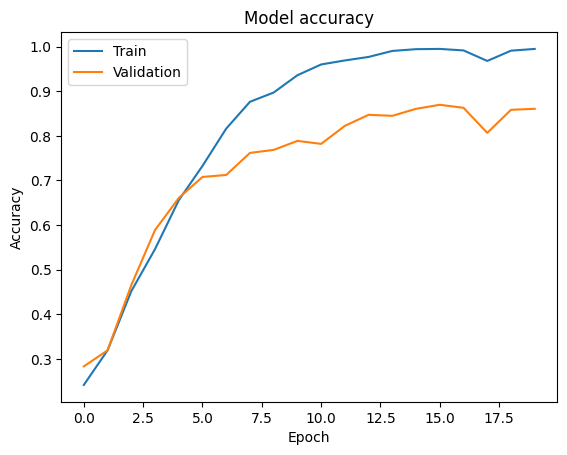

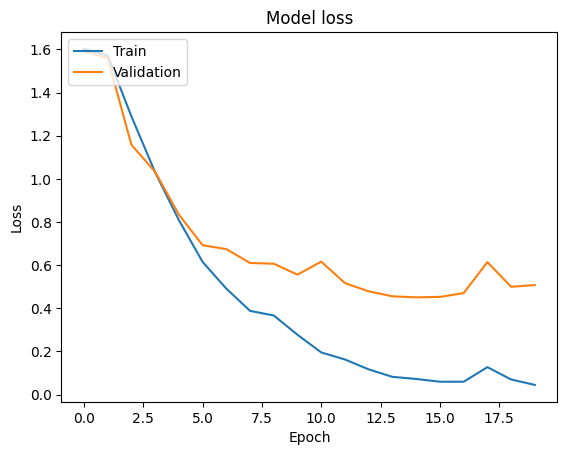

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stop=EarlyStopping(monitor='val_loss',patience=10)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_padded, training_label_seq, epochs=50,
                    validation_data=(validation_padded, validation_label_seq),
                    callbacks=[reduce_lr,early_stop])

Epoch 1/50
56/56 [==============================] - 3s 29ms/step - loss: 0.0502 - accuracy: 0.9893 - val_loss: 0.6664 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 1s 12ms/step - loss: 0.0348 - accuracy: 0.9944 - val_loss: 0.5845 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 1s 12ms/step - loss: 0.0330 - accuracy: 0.9961 - val_loss: 0.5190 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 1s 13ms/step - loss: 0.0199 - accuracy: 0.9994 - val_loss: 0.5688 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 1s 13ms/step - loss: 0.0622 - accuracy: 0.9876 - val_loss: 0.6981 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 1s 12ms/step - loss: 0.0218 - accuracy: 0.9972 - val_loss: 0.5960 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 1s 13ms/step - loss: 0.0

In [28]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.050161,0.989326,0.666388,0.835955,0.001000
1,0.034783,0.994382,0.584459,0.833708,0.001000
2,0.033045,0.996067,0.519027,0.876405,0.001000
3,0.019925,0.999438,0.568775,0.849438,0.001000
4,0.062177,0.987640,0.698054,0.835955,0.001000
5,0.021796,0.997191,0.595990,0.858427,0.001000
6,0.016905,0.998315,0.594227,0.862921,0.000100
7,0.014523,0.999438,0.588335,0.867416,0.000100
8,0.016092,0.999438,0.585971,0.867416,0.000100
9,0.015407,1.000000,0.585517,0.867416,0.000010


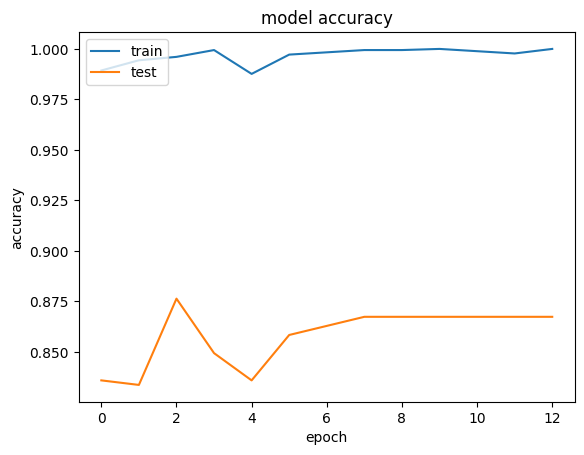

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

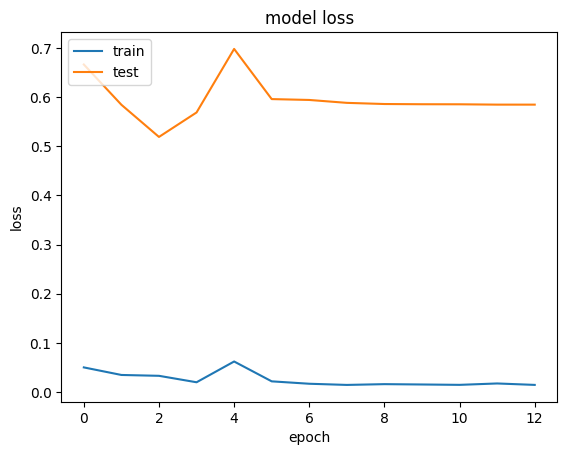

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
y_pred=model.predict(validation_padded)

14/14 [==============================] - 1s 6ms/step


In [32]:
pred=[np.argmax(i) for i in tqdm(y_pred)]
df=pd.DataFrame()
df['Prediction'],df['actual']=pred,validation_label_seq
df

100%|██████████| 445/445 [00:00<00:00, 223101.28it/s]


,Prediction,actual
0,4,4
1,3,3
2,0,0
3,2,2
4,2,2
...,...,...
440,1,1
441,0,0
442,3,4
443,0,0


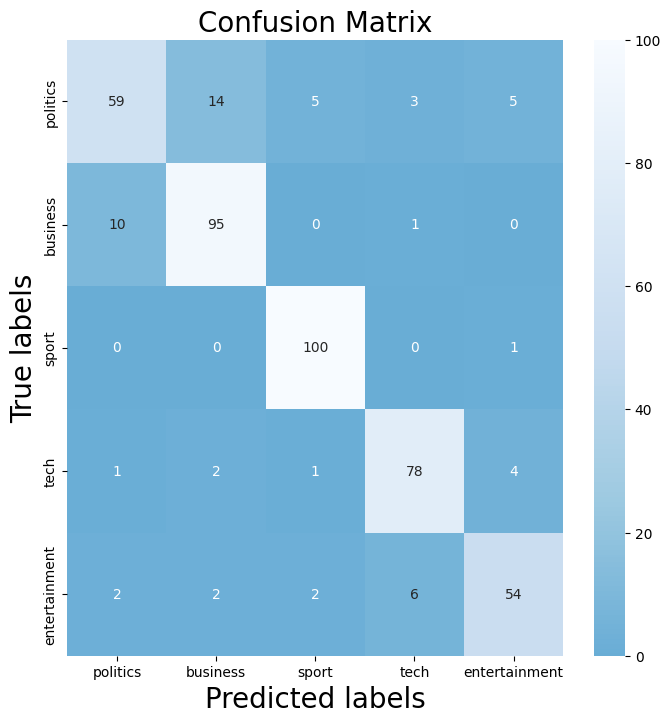

array([[ 59,  14,   5,   3,   5],
       [ 10,  95,   0,   1,   0],
       [  0,   0, 100,   0,   1],
       [  1,   2,   1,  78,   4],
       [  2,   2,   2,   6,  54]], dtype=int64)

In [33]:
CM = confusion_matrix(validation_label_seq,pred)
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(CM, center = True, fmt='g',ax=ax,annot=True,cmap='Blues_r')
ax.set_xlabel('Predicted labels',fontsize=20)
ax.set_ylabel('True labels',fontsize=20)
ax.set_title('Confusion Matrix',fontsize=20)
ax.xaxis.set_ticklabels(dict_.keys())
ax.yaxis.set_ticklabels(dict_.keys())
plt.show()
CM

In [34]:
ClassificationReport = classification_report(validation_label_seq,pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.82      0.69      0.75        86
           1       0.84      0.90      0.87       106
           2       0.93      0.99      0.96       101
           3       0.89      0.91      0.90        86
           4       0.84      0.82      0.83        66

    accuracy                           0.87       445
   macro avg       0.86      0.86      0.86       445
weighted avg       0.87      0.87      0.86       445

